### Image Descriptors

The process of quantifying an image is called feature extraction. The process of feature extraction governs the rules, algorithms, and methodologies we use to abstractly quantify the contents of an image using only a list of numbers, called a feature vector.

Image descriptors and feature descriptors govern how an image is abstracted and quantified, while feature vectors are the output of descriptors and used to quantify the image. Taken as a whole, this process is called feature extraction.

In [1]:
import cv2
import os
import random
random.seed(255)
import imutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display(image, flip=True, cmap=None, figsize=(6, 6), **kwargs):
    if flip:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    # adjustment for histograms
    if kwargs.get("is_histogram", False):
        plt.figure(figsize=figsize)
        plt.plot(image)
    else:
        width=image.shape[1] 
        height=image.shape[0]
        margin=50 
        # dots per inch
        dpi=100.
        # inches
        figsize=((width+2*margin)/dpi, (height+2*margin)/dpi)
        #axes ratio
        left = margin/dpi/figsize[0] 
        bottom = margin/dpi/figsize[1]
        fig = plt.figure(figsize=figsize, dpi=dpi)
        fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom)
        _ = plt.imshow(image, cmap=cmap)
        plt.axis("off")
    plt.title(kwargs.get("title", None))
    plt.xlabel(kwargs.get("xlabel", None))
    plt.ylabel(kwargs.get("ylabel", None))
    plt.xlim(kwargs.get("xlim", None))
    plt.show()
    
def display_histogram(histograms, figsize=(6, 6), **kwargs):
    plt.figure(figsize=figsize)
    plt.title(kwargs.get("title", None))
    plt.xlabel(kwargs.get("xlabel", None))
    plt.ylabel(kwargs.get("ylabel", None))
    plt.xlim(kwargs.get("xlim", None))
    for h, c in histograms:
        plt.plot(h, color=c)
    plt.show()


#### Objectives

1. Feature vector
2. Image descriptor
3. Feature descriptor


**1. Image Feature Vector:** An abstraction of an image used to characterize and numerically quantify the contents of an image. Normally real, integer, or binary valued. Simply put, a feature vector is a list of numbers used to represent an image.


**Simply put: a feature vector is nothing more than a list of numbers used to represent and quantify an image.**

-----------------------------------------------------------------------------------------------------------------

**2. Image Descriptor:** An image descriptor is an algorithm and methodology that governs how an input image is globally quantified and returns a feature vector abstractly representing the image contents.

The key term to understand here is **global** — this implies that we are examining the entire image and using the whole image in the computation of our feature vector.

-----------------------------------------------------------------------------------------------------------------

**3. Feature Descriptor:** A feature descriptor is an algorithm and methodology that governs how an input region of an image is locally quantified. A feature descriptor accepts a single input image and returns multiple feature vectors.

### Color channel statistics

The color channel image descriptor can be broken down into three steps:

- **Step 1:** Separate the input image into its respective channels. For an RGB image, we want to examine each of the Red, Green, and Blue channels independently.
- **Step 2:** Compute various statistics for each channel, such as mean, standard deviation, skew, and kurtosis.
- **Step 3:** Concatenate the statistics together to form a “list” of statistics for each color channel — this becomes our feature vector.

In [2]:
from scipy.spatial import distance as dist
from imutils import paths

In [3]:
images = sorted(list(paths.list_images("images/dinos/")))
print(len(images))
index = dict()

4


In [4]:
# loop over
for image in images:
    # read
    img = cv2.imread(image)
    filename = image[image.rfind("/") + 1:]
    
    # extract the mean and standard deviation from each channel of the
    # BGR image, then update the index with the feature vector
    (means, stds) = cv2.meanStdDev(img)
    features = np.concatenate([means, stds]).flatten()
    index[filename] = features

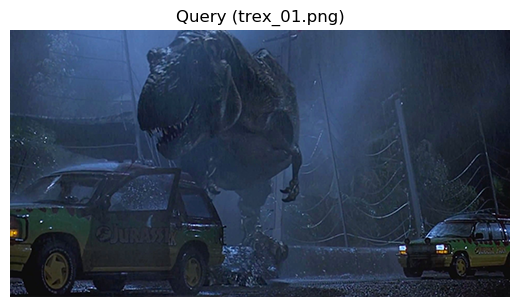

In [5]:
query = cv2.imread(images[0])
display(query, title="Query (trex_01.png)")

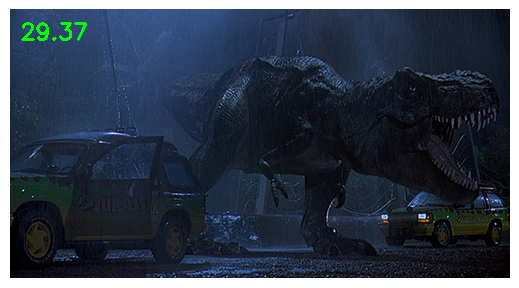

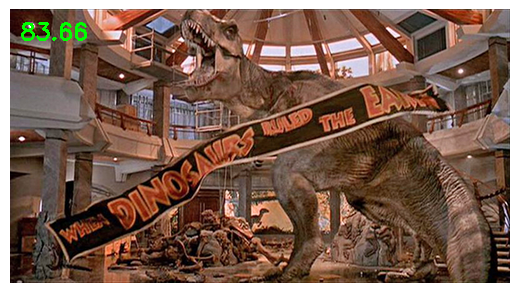

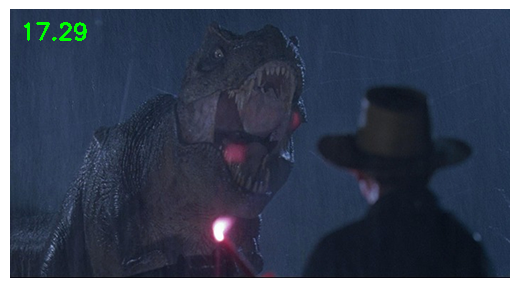

In [6]:
keys = sorted(index.keys())

# loop over
for i, k in enumerate(keys):
    # if first
    if k == "trex_01.png":
        continue
    
    # load the image
    image = cv2.imread(images[i])
    # calculate euclidean distance between two images
    d = dist.euclidean(index["trex_01.png"], index[k])
    # display the distance between the query image and the current image
    cv2.putText(image, "%.2f" % (d), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    display(image)
    
    

In [8]:
image = cv2.imread("images/raptors_01.png")
mean,std = cv2.meanStdDev(image)
concat1 = np.concatenate([mean, std]).flatten()
concat1

array([33.40508234, 29.97264203, 39.20540541, 27.05237628, 23.14341739,
       24.45663121])

In [9]:
image = cv2.imread("images/raptors_02.png")
mean,std = cv2.meanStdDev(image)
concat2 = np.concatenate([mean, std]).flatten()
concat2

array([32.91972059, 31.70267647, 41.27877941, 32.2467483 , 24.12363825,
       24.84446949])

In [10]:
d = dist.euclidean(concat1, concat2)
d

5.968268349855276

### Color Histograms


In [19]:
from sklearn.cluster import KMeans
class LabHistogram:
    
    def __init__(self, bins):
        self.bins = bins
    
    def describe(self, image, mask=None):
        
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        hist = cv2.calcHist([lab], [0, 1, 2], mask, self.bins, [0, 256, 0, 256, 0, 256])
        
        # normalize
        hist = cv2.normalize(hist, hist).flatten()
        return hist


In [31]:
desc = LabHistogram(bins=[8, 8, 8])
data = []

In [32]:
paths_ = list(paths.list_images("images/color_histogram/"))
paths_ = np.array(sorted(paths_))
paths_

array(['images/color_histogram/antelopecanyon_01.png',
       'images/color_histogram/antelopecanyon_02.png',
       'images/color_histogram/antelopecanyon_03.png',
       'images/color_histogram/antelopecanyon_04.png',
       'images/color_histogram/antelopecanyon_05.png',
       'images/color_histogram/grandcanyon_01.png',
       'images/color_histogram/grandcanyon_02.png',
       'images/color_histogram/grandcanyon_03.png',
       'images/color_histogram/grandcanyon_04.png',
       'images/color_histogram/grandcanyon_05.png'], dtype='<U44')

In [33]:
# loop over
for path in paths_:
    image = cv2.imread(path)
    hist = desc.describe(image)
    data.append(hist)
    
cls = KMeans(n_clusters=2)
labels = cls.fit_predict(data)
labels

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

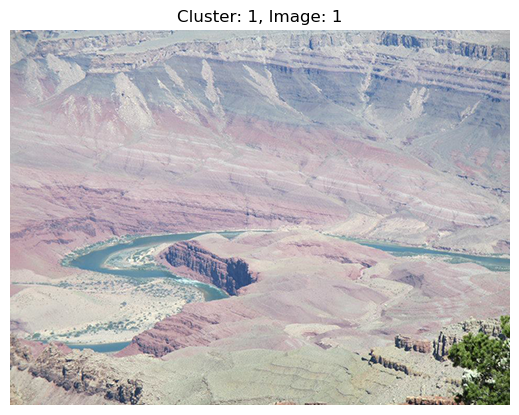

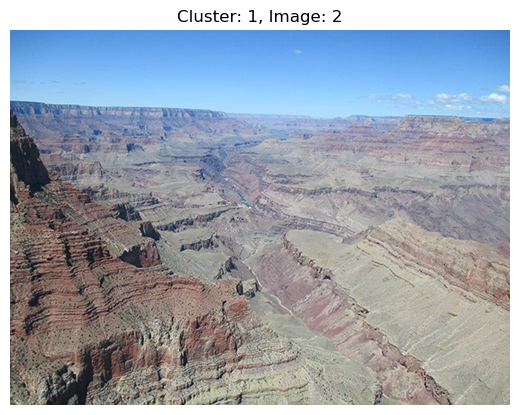

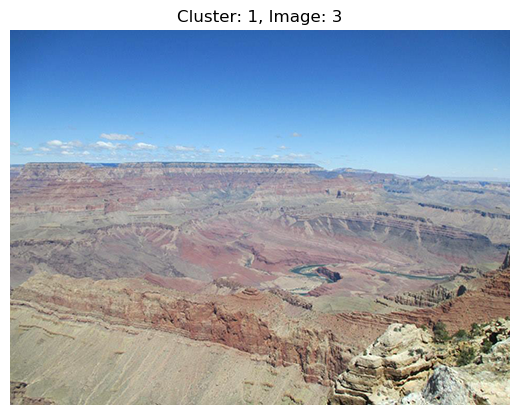

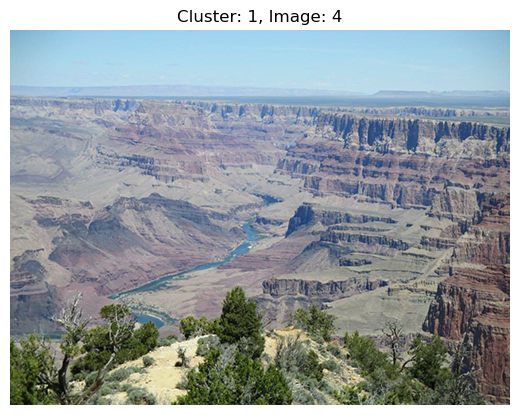

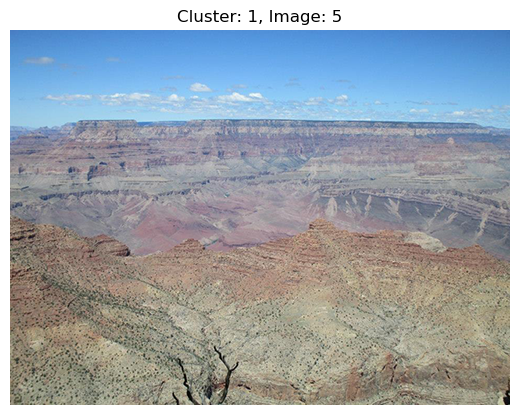

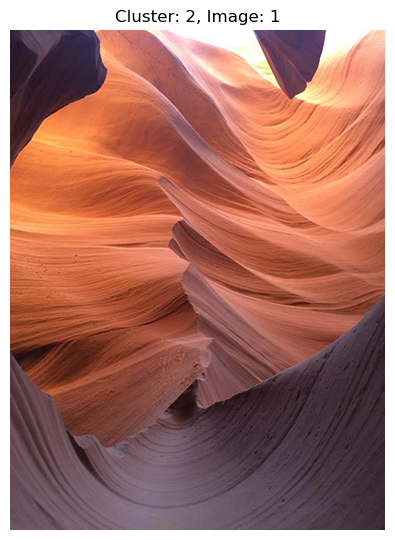

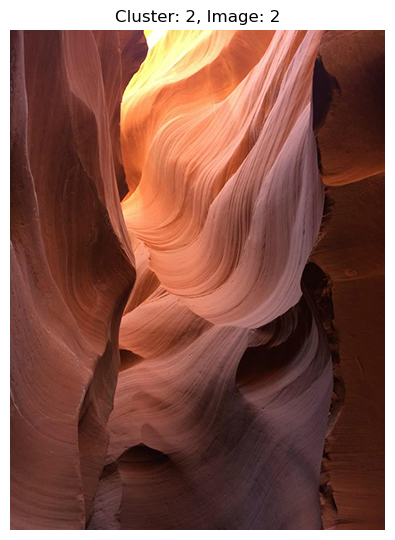

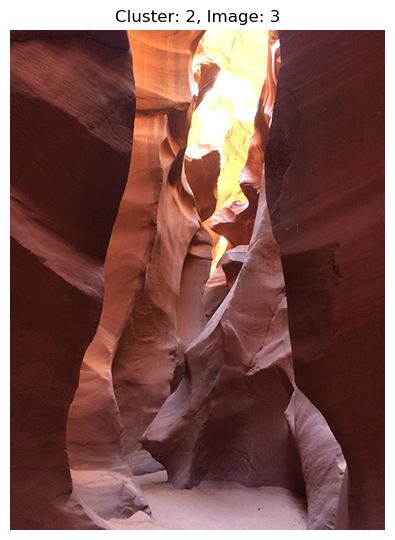

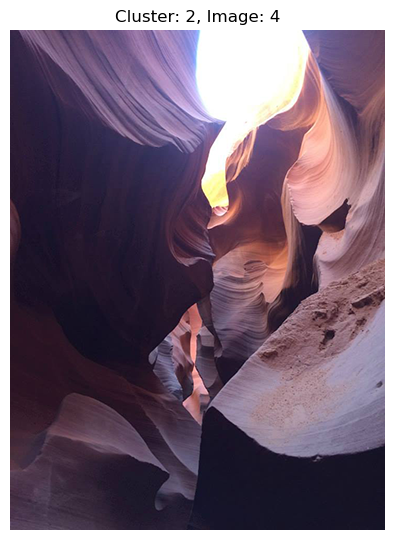

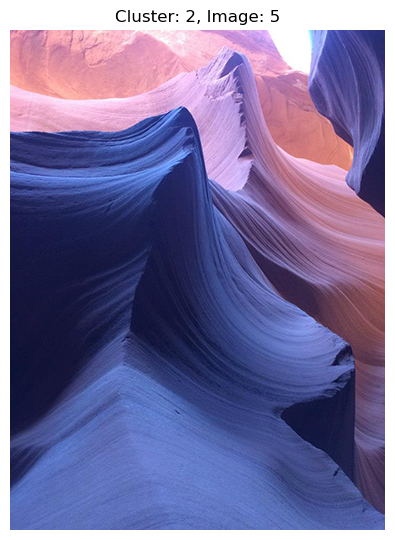

In [34]:
# loop over and display labels
for label in np.unique(labels):
    label_paths = paths_[np.where(labels == label)]
    
    # loop over paths
    for i, path in enumerate(label_paths):
        image = cv2.imread(path)
        display(image, title="Cluster: {}, Image: {}".format(label+1, i+1))

### Hu Moments

In [35]:
image = cv2.imread("images/planes.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Original Moments: [ 8.89880773e-03  7.57204412e-05  2.38651674e-08  1.85900330e-08
  3.91558010e-16  1.61708196e-10 -2.12085766e-18]


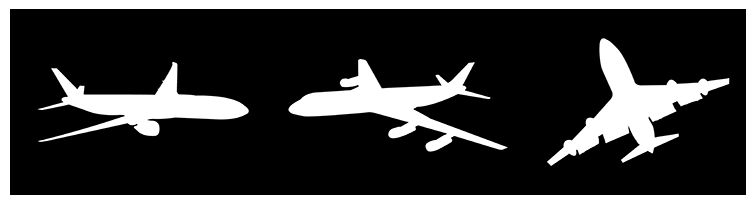

In [36]:
# INCORRECT WAY OF CALCULATING HU MOMENTS 
# compute hu moments feature vector for entire image
moments = cv2.HuMoments(cv2.moments(image)).flatten()
print("Original Moments: {}".format(moments))
display(image, flip=False, cmap="gray")

Moments for plane #1: [2.00162991e-03 3.01754249e-06 3.08984971e-11 4.14364409e-11
 4.97600769e-22 5.93897843e-14 1.39666817e-21]


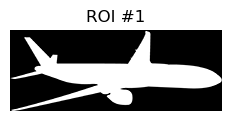

Moments for plane #2: [ 1.80851599e-03  1.92184829e-06  5.41577862e-10  4.41334901e-11
  5.46923123e-21 -2.19817014e-14 -4.07951523e-21]


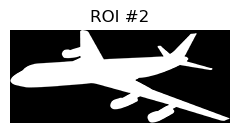

Moments for plane #3: [1.18498670e-03 1.91160278e-07 5.89818694e-10 2.59586273e-14
 8.63387433e-26 2.03739557e-18 5.35057510e-26]


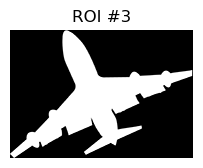

In [37]:
# CORRECT WAY OF CALCULATING MOMENTS

# first find contours
contours = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

# loop over each contour
for i, c in enumerate(contours):
    # extract the ROI from the image and compute HU MOMENTS feature
    # vector for the ROI
    (x, y, w, h) = cv2.boundingRect(c)
    # crop the object area from the original image
    roi = image[y:y+h, x:x+w]
    # calculate Hu Moments for ROI
    moments = cv2.HuMoments(cv2.moments(roi)).flatten()
    
    print("Moments for plane #{}: {}".format(i+1, moments))
    display(roi, flip=False, cmap="gray", title="ROI #{}".format(i+1))

#### OUTLIER DETECTION PROJECT

In [38]:
import uuid
import numpy as np

In [40]:
# define N
num_images = 500
output_dir = "images/outlier"

for i in range(0, num_images):
    """
    allocate memory for the image, then generate the (x, y)
    center of the circle, then generate the radius of the
    circle, ensuring that the circle is fully contained in
    the image 
    """
    image = np.zeros((500, 500, 3), dtype="uint8")
    (x, y) = np.random.uniform(low=105, high=395, size=(2,)).astype("int0")
    r = np.random.uniform(low=25, high=100, size=(1, )).astype("int0")[0]
    """
    randomly generate a color for the circle, draw it, and
    write the image to file using a random filename
    """
    color = np.random.uniform(low=0, high=255, size=(3,)).astype("int0")
    color = tuple(map(int, color))
    cv2.circle(image, (x, y), r, color, -1)
    cv2.imwrite("{}/{}.jpg".format(output_dir, uuid.uuid4()), image)
        
    

In [41]:
# generate one random rectangle 
# allocate memory for the rectangle image, then generate the starting
# and ending (x, y) coordinates of the square
image = np.zeros((500, 500, 3), dtype="uint8")
top_left = np.random.uniform(low=25, high=225, size=(2,)).astype("int0")
bottom_right = np.random.uniform(low=250, high=400, size=(2,)).astype("int0")

# draw the rectangle on the image and write it to file, again,
# using a random filename
color = np.random.uniform(low=0, high=255, size=(3,)).astype("int0")
color = tuple(map(int, color))
cv2.rectangle(image, tuple(top_left), tuple(bottom_right), color, -1)
cv2.imwrite("{}/{}.jpg".format(output_dir, uuid.uuid4()), image)

True

In [42]:
from sklearn.metrics.pairwise import pairwise_distances
import glob

In [43]:
image_paths = sorted(glob.glob(output_dir + "/*.jpg"))
data = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)[1]
    
    # find contours in the image, keep only largest one
    contours = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = max(contours, key=cv2.contourArea)
    
    # extract ROI, resize it to canonical size
    (x, y, w, h) = cv2.boundingRect(contours)
    roi = cv2.resize(thresholded[y:y+h, x:x+w], (50, 50))
    moments = cv2.HuMoments(cv2.moments(roi)).flatten()
    data.append(moments)